In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import seaborn as sns
import glob
import sys
from collections import Counter

In [2]:
sys.path.append(os.path.abspath("../QALD9-Plus-testing/sparql_evaluation"))
from plot_error_label_distribution_single import plot_error_label_distribution

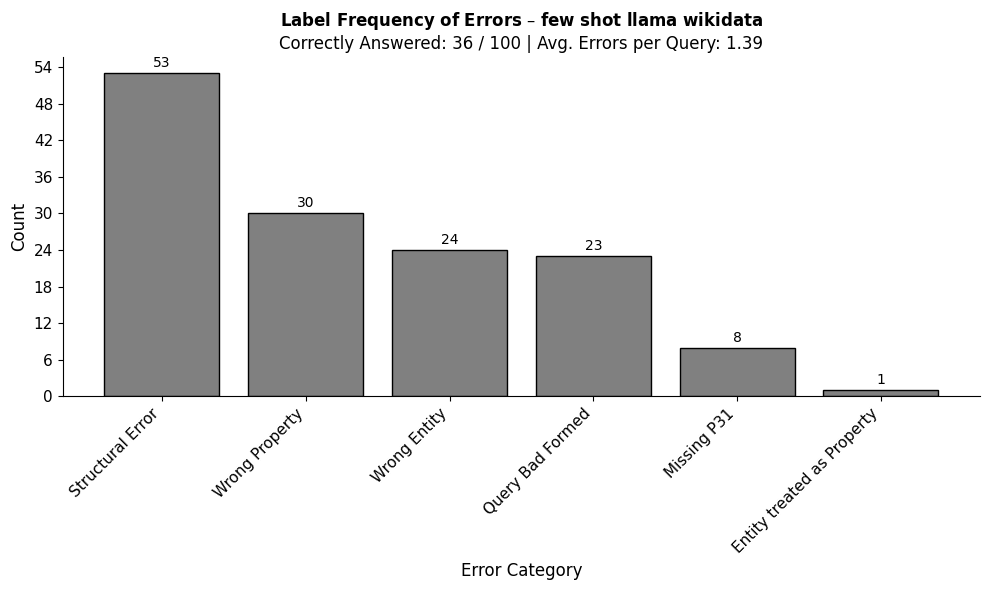

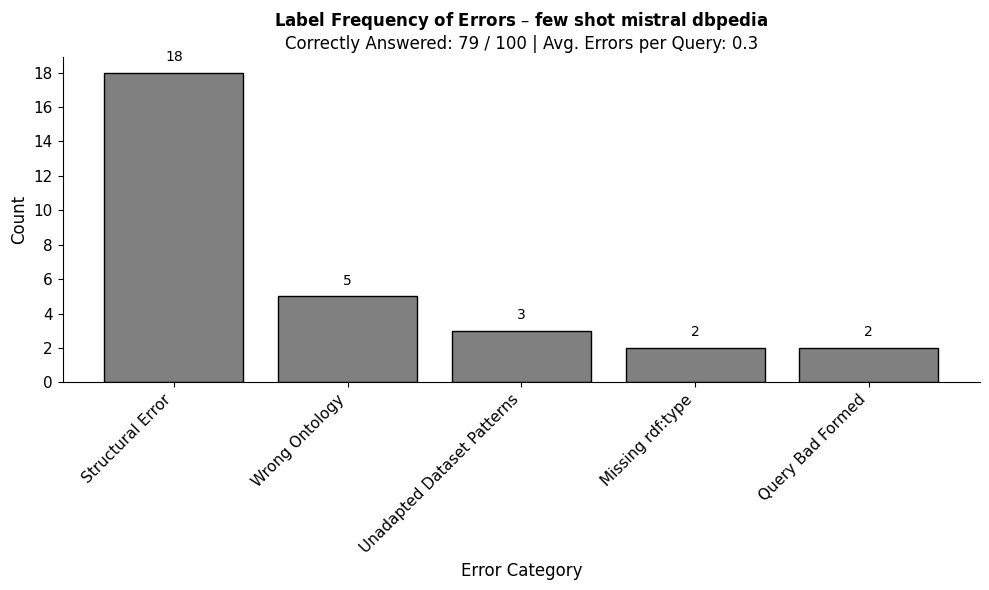

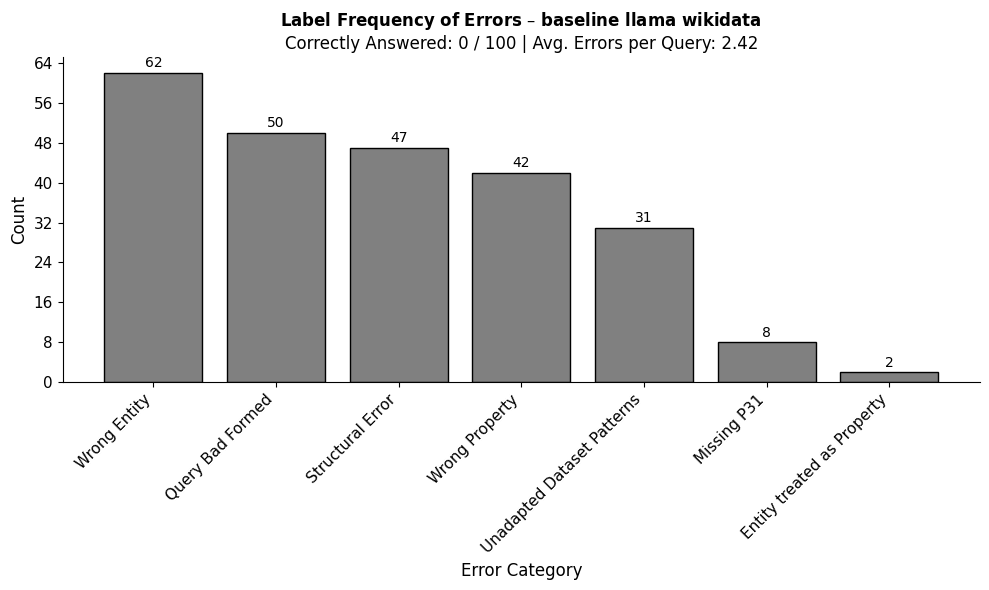

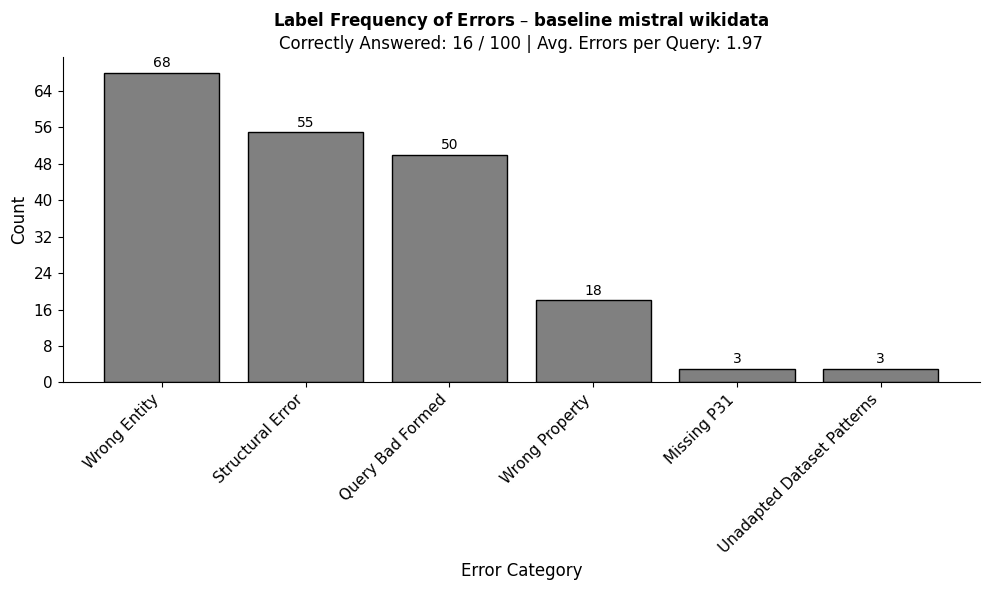

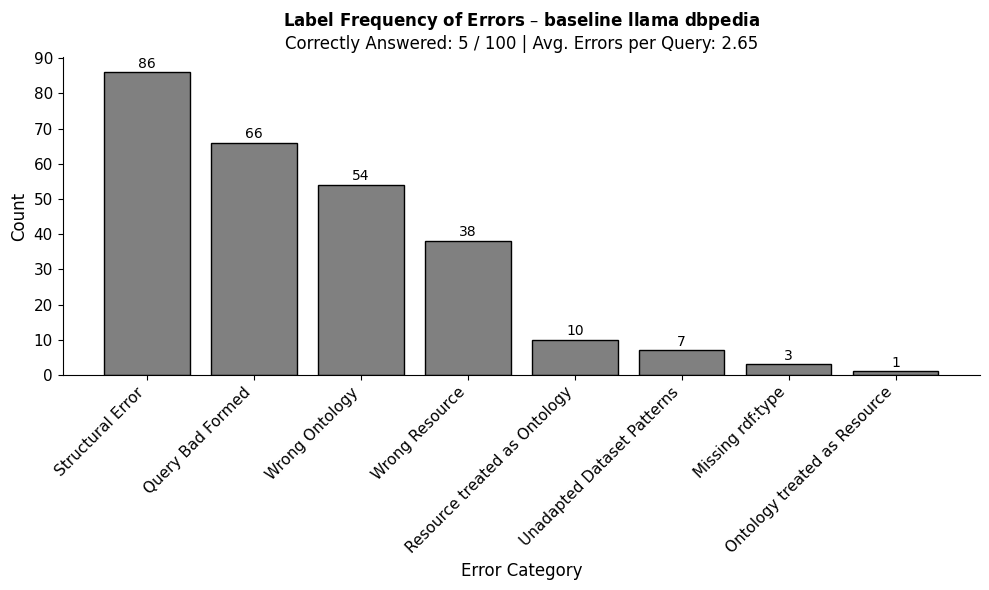

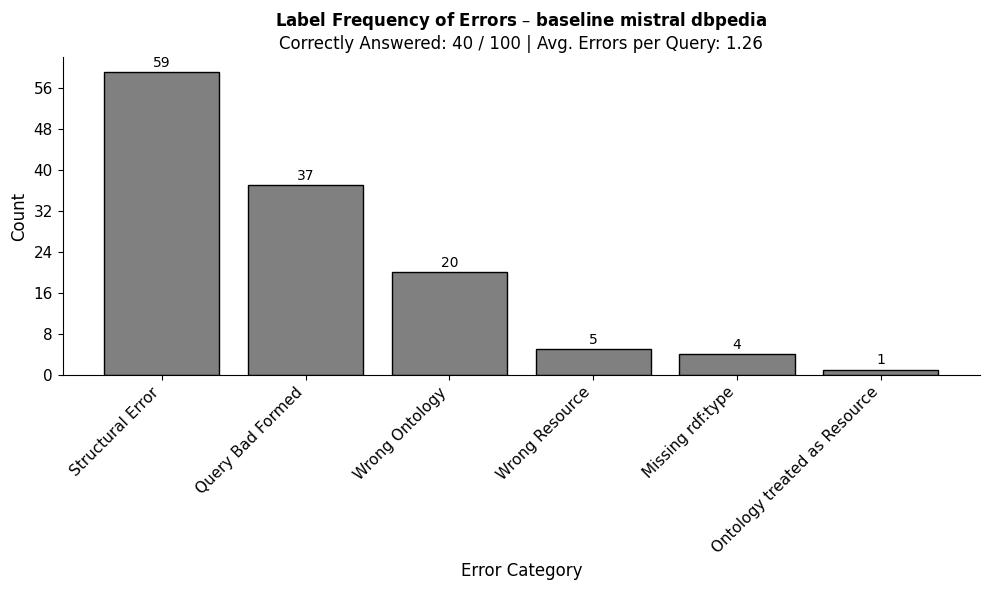

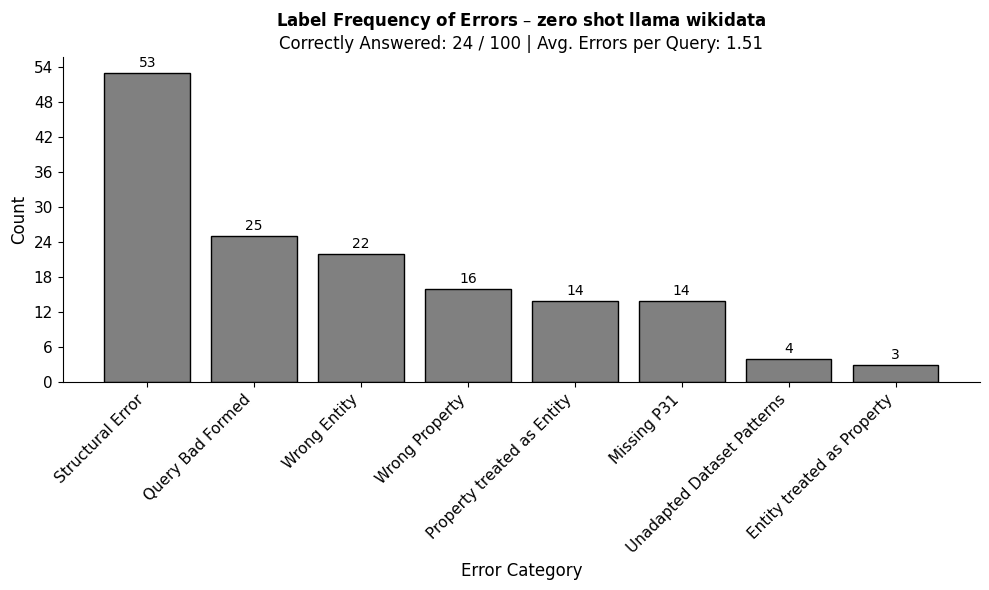

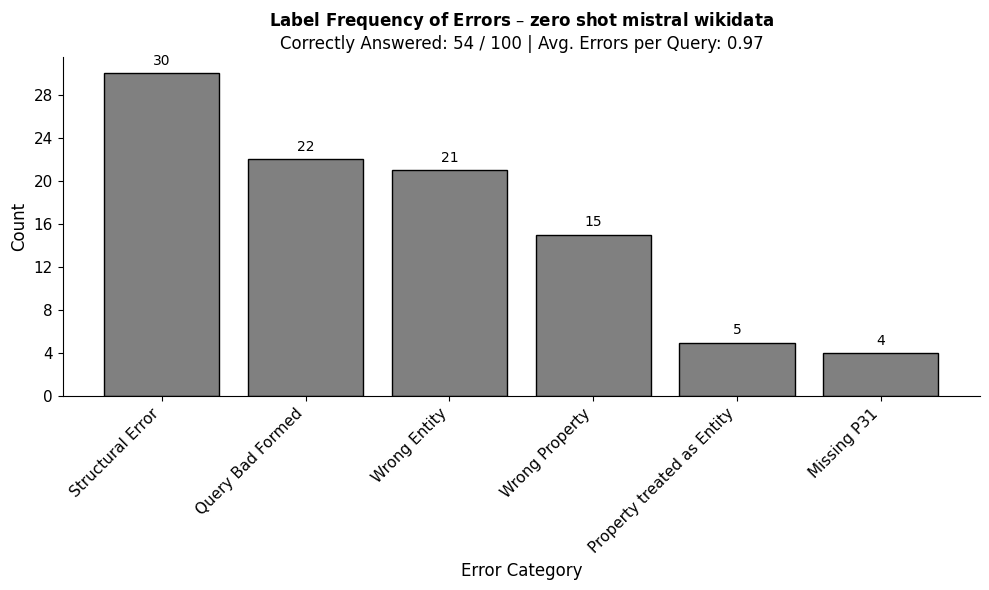

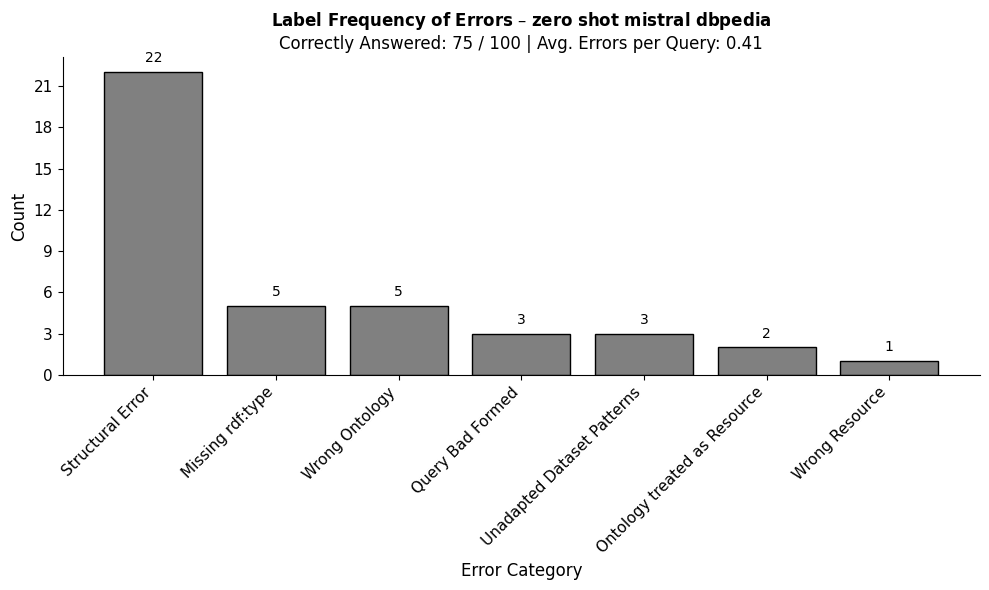

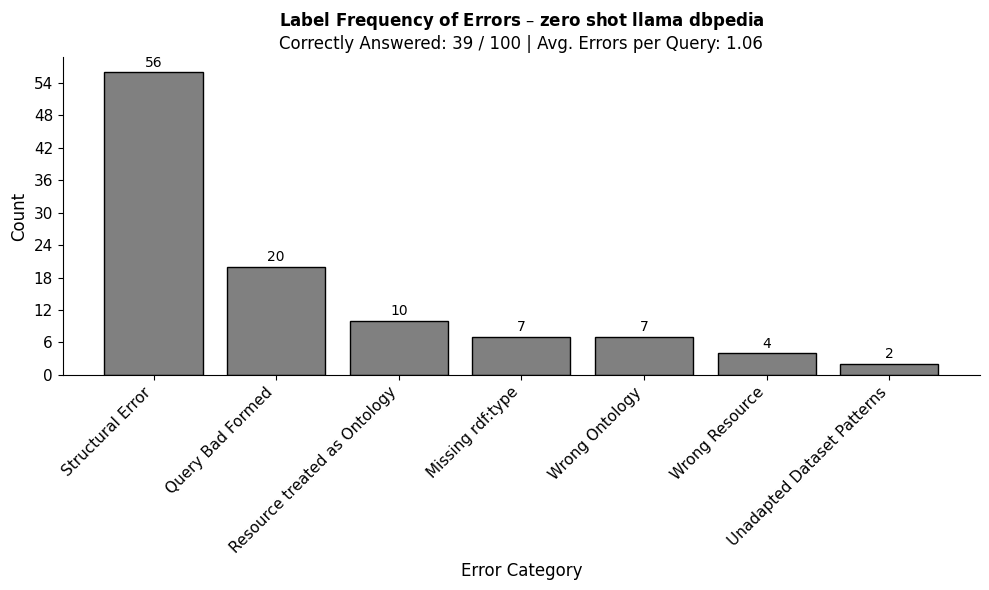

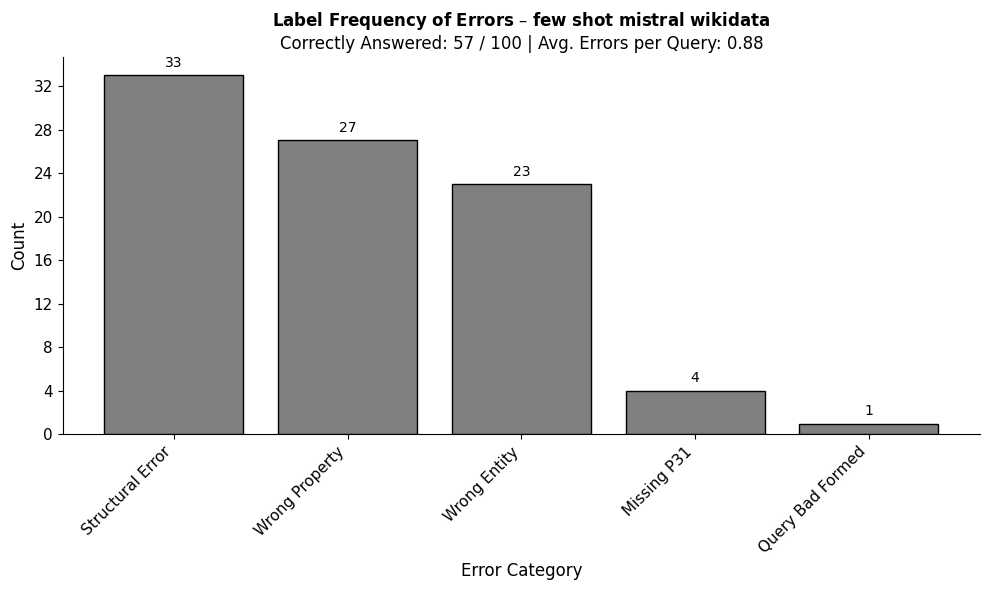

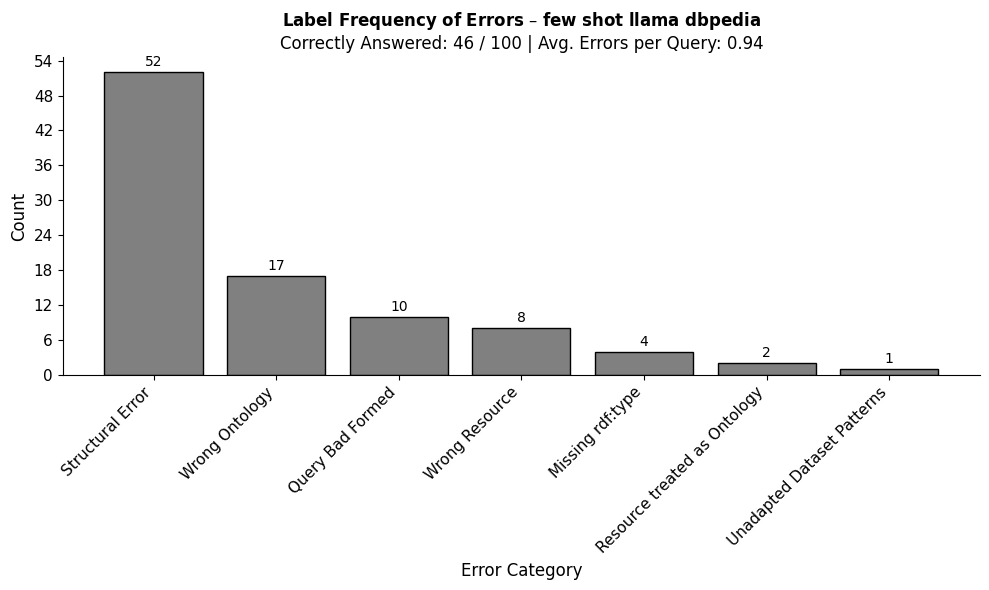

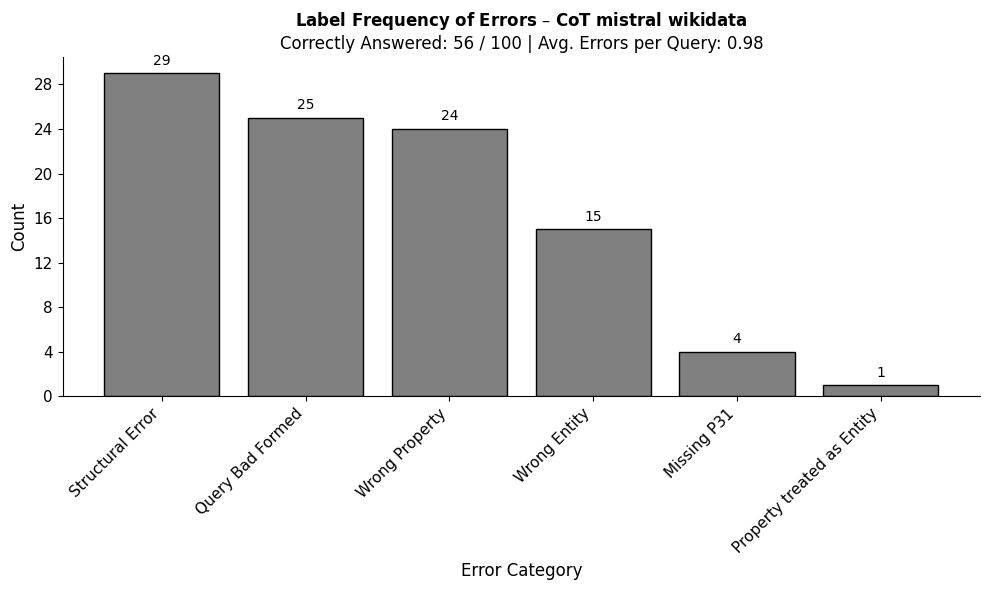

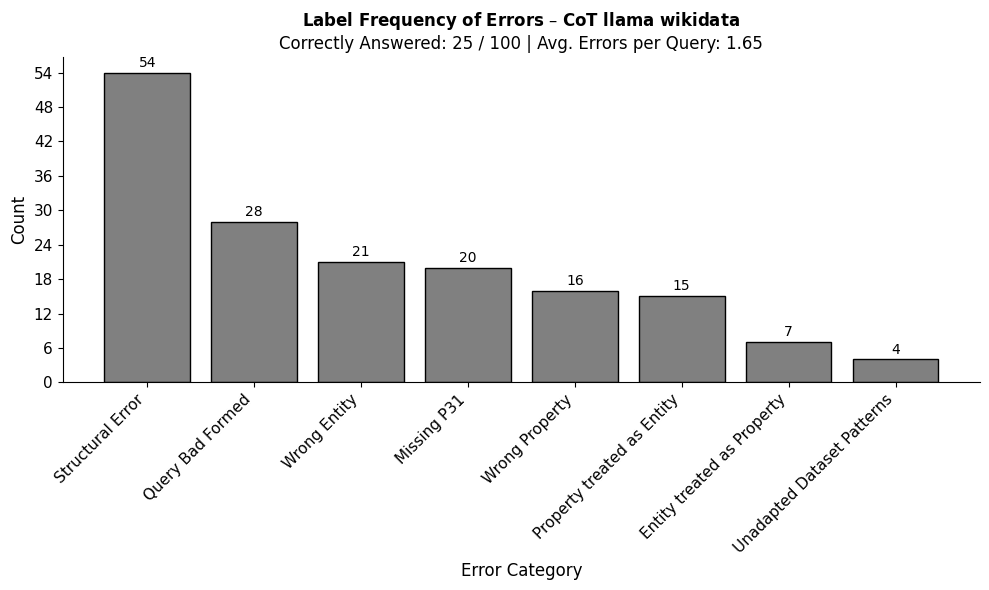

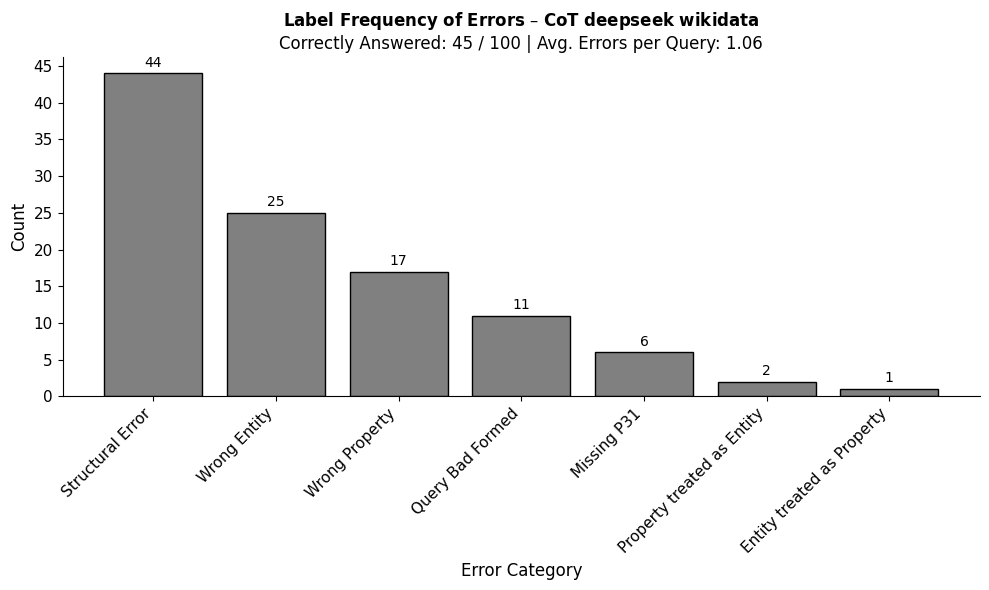

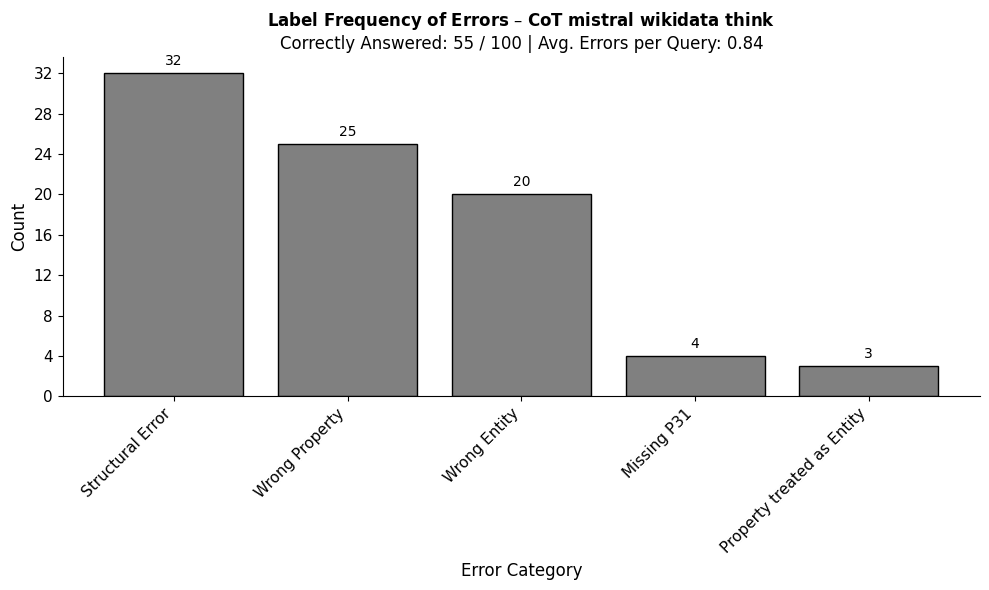

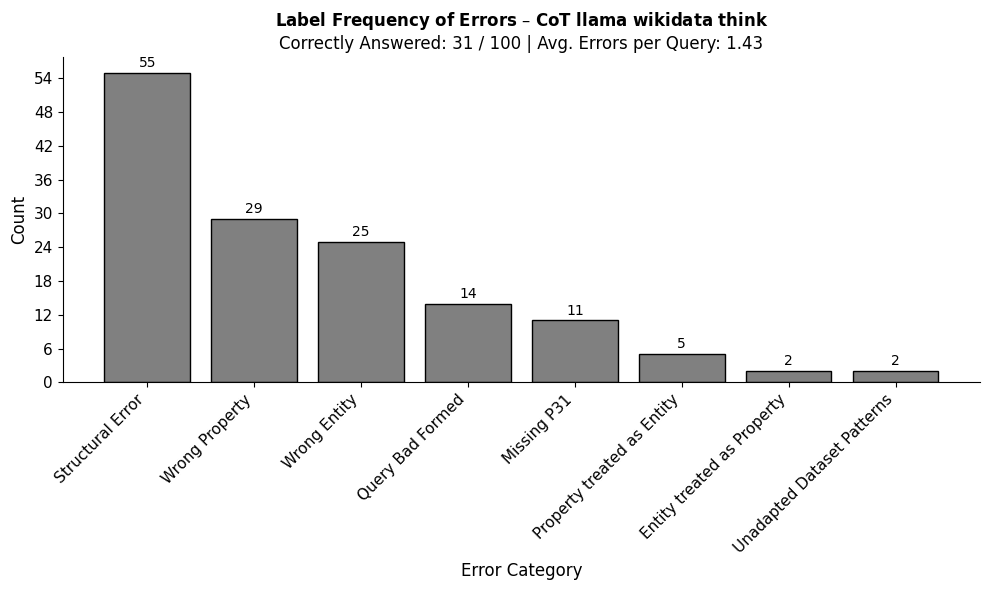

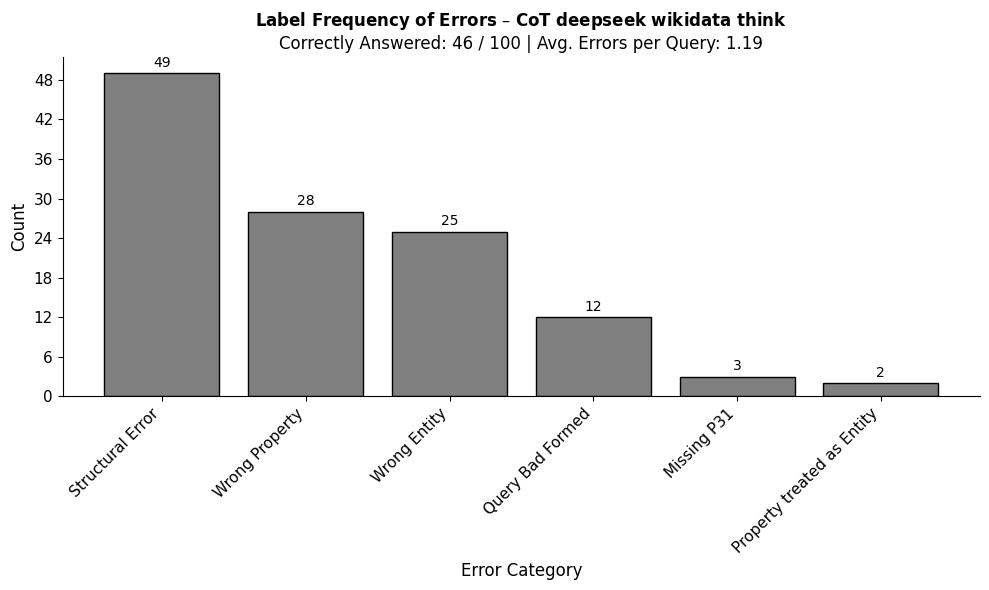

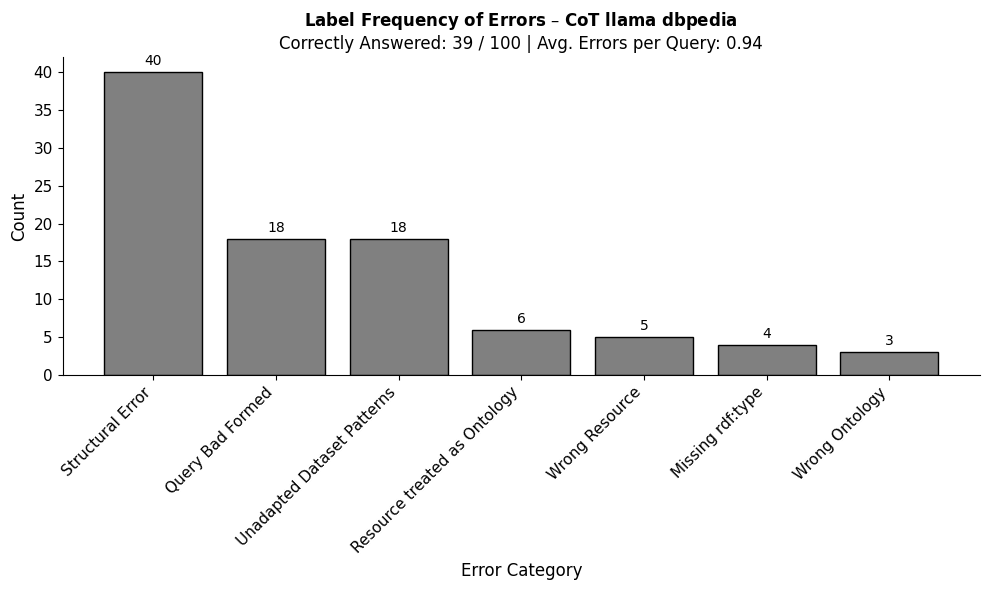

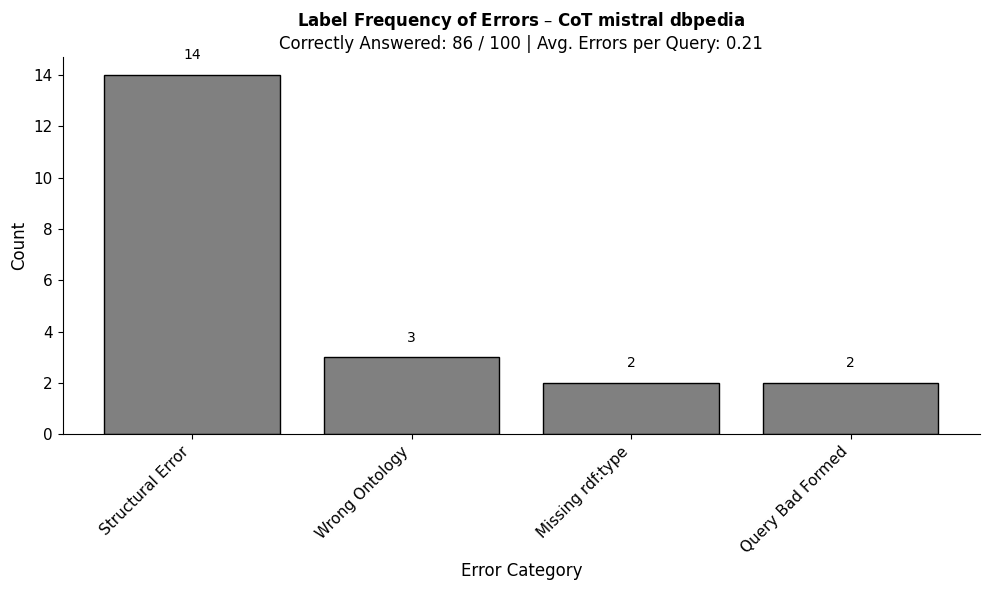

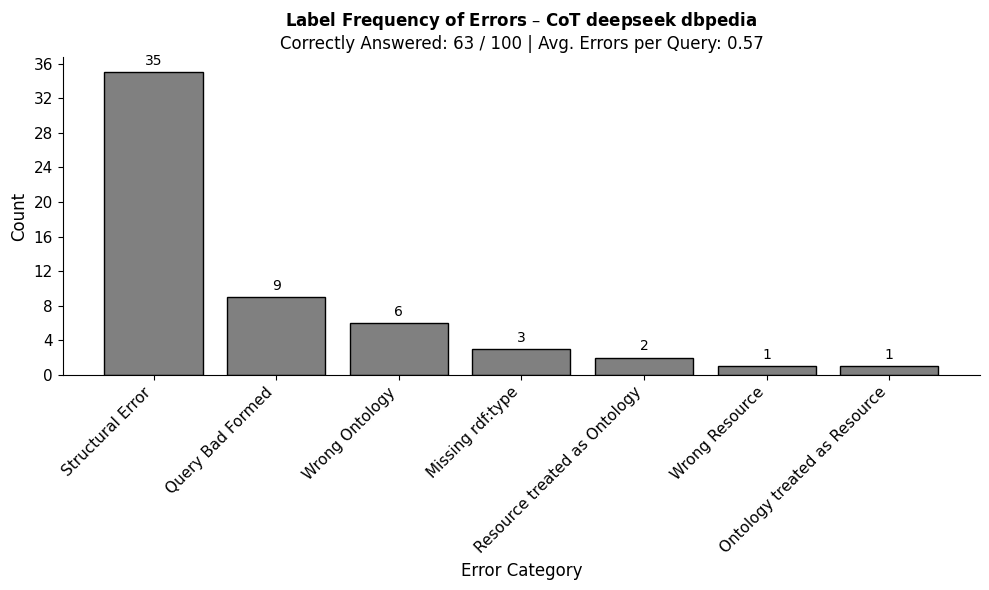

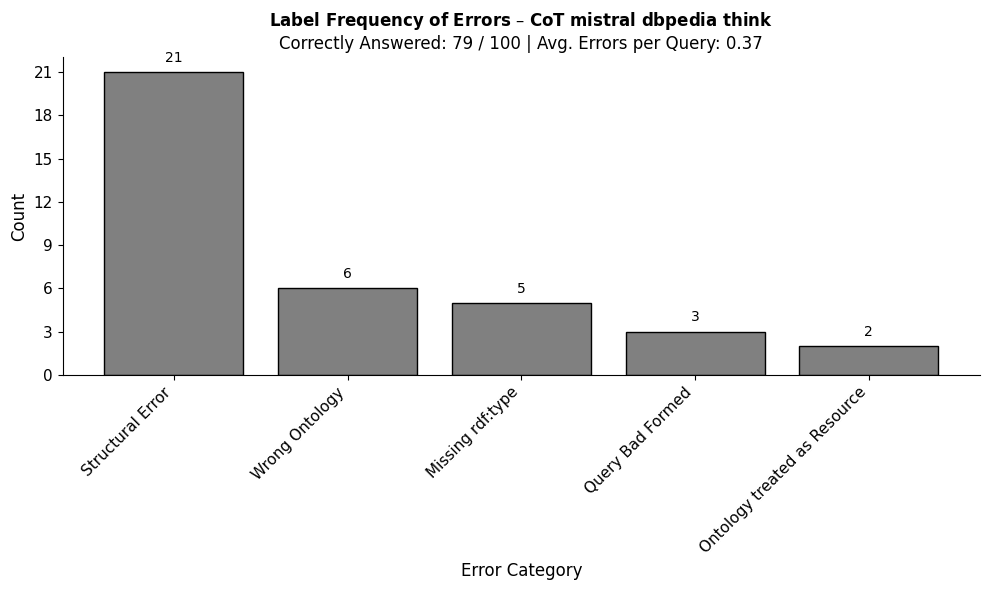

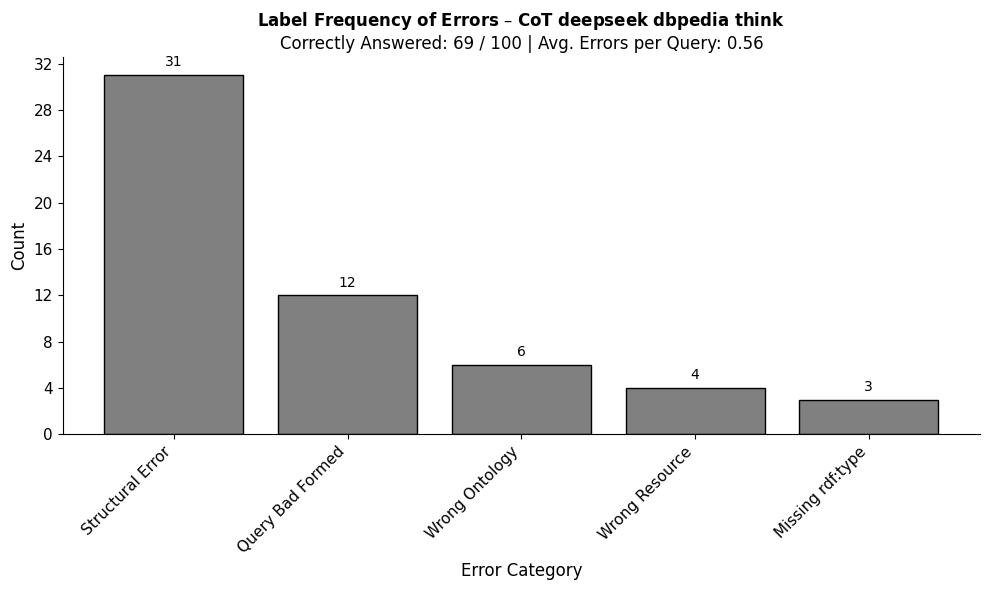

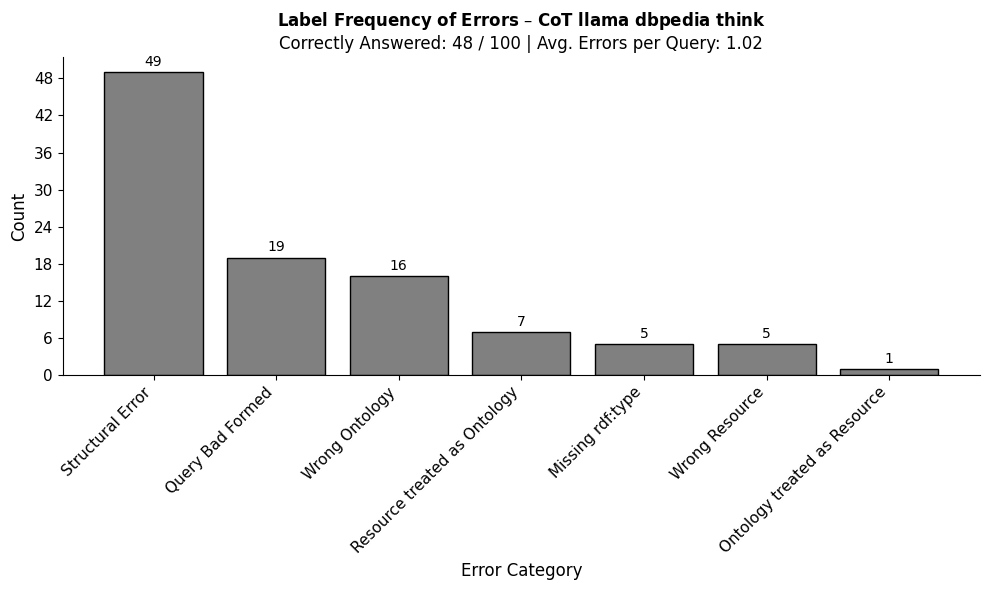

In [3]:
file_paths = glob.glob("categorization/*_results_analysis.xlsx")

for path in file_paths:
    plot_error_label_distribution(path)

Summarize most common errors and average errors per query

In [4]:
summary = []

for path in glob.glob("categorization/*_results_analysis.xlsx"):
    model_name = os.path.basename(path).replace("_results_analysis.xlsx", "")
    df = pd.read_excel(path)
    
    correct = df[df['Correct'] == True]
    incorrect = df[df['Correct'] != True]
    total = len(df)
    num_correct = len(correct)

    error_cols = ["Error Category", "Error Category 2", "Error Category 3", "Error Category 4"]
    existing_cols = [col for col in error_cols if col in incorrect.columns]
    all_errors = incorrect[existing_cols].stack().dropna()
    most_common_errors = ", ".join(all_errors.value_counts().head(3).index)
    avg_errors_per_query = round(len(all_errors) / total, 3)

    summary.append({
        "Model": model_name,
        "Correct / Total": f"{num_correct} / {total}",
        "Avg. Errors per Query": avg_errors_per_query,
        "Most Common Errors": most_common_errors
    })

summary_df = pd.DataFrame(summary)
summary_df = summary_df.sort_values(by="Avg. Errors per Query", ascending=True)

summary_df.to_excel("model_error_summary.xlsx", index=False)

summary_df


,Model,Correct / Total,Avg. Errors per Query,Most Common Errors
19,CoT_mistral_dbpedia,86 / 100,0.21,"Structural Error, Wrong Ontology, Missing rdf:..."
1,few_shot_mistral_dbpedia,79 / 100,0.30,"Structural Error, Wrong Ontology, Unadapted Da..."
21,CoT_mistral_dbpedia_think,79 / 100,0.37,"Structural Error, Wrong Ontology, Missing rdf:..."
8,zero_shot_mistral_dbpedia,75 / 100,0.41,"Structural Error, Missing rdf:type, Wrong Onto..."
22,CoT_deepseek_dbpedia_think,69 / 100,0.56,"Structural Error, Query Bad Formed, Wrong Onto..."
20,CoT_deepseek_dbpedia,63 / 100,0.57,"Structural Error, Query Bad Formed, Wrong Onto..."
15,CoT_mistral_wikidata_think,55 / 100,0.84,"Structural Error, Wrong Property, Wrong Entity"
10,few_shot_mistral_wikidata,57 / 100,0.88,"Structural Error, Wrong Property, Wrong Entity"
11,few_shot_llama_dbpedia,46 / 100,0.94,"Structural Error, Wrong Ontology, Query Bad Fo..."
18,CoT_llama_dbpedia,39 / 100,0.94,"Structural Error, Query Bad Formed, Unadapted ..."


Total errors per knowledge graph

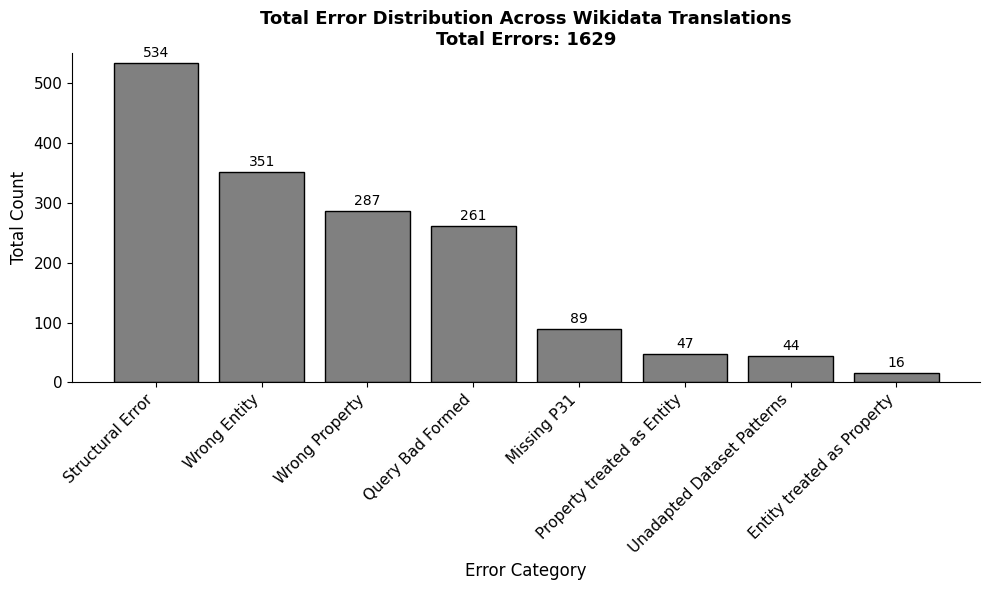

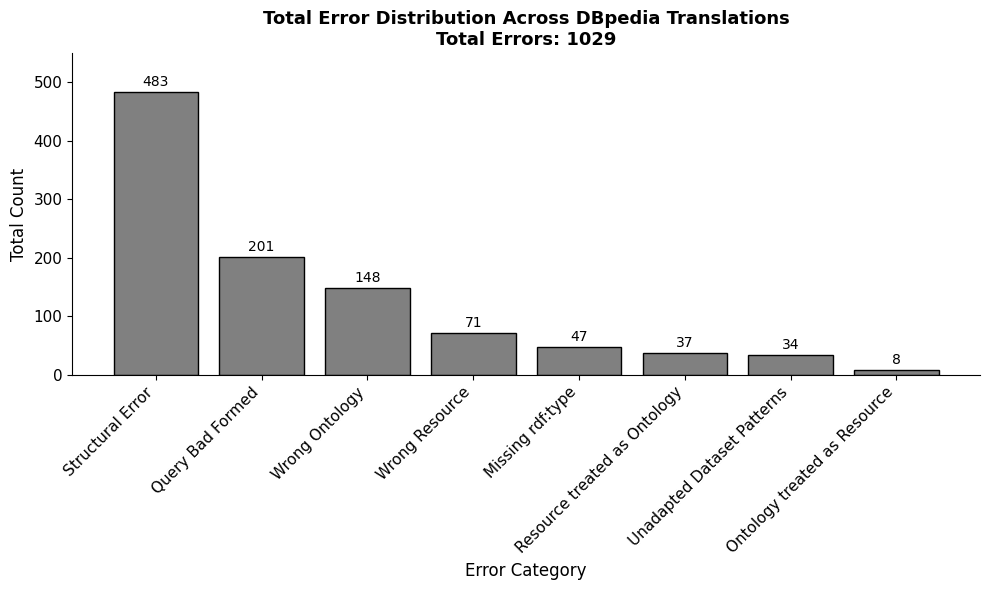

In [5]:
# Initialize counters
wikidata_errors = Counter()
dbpedia_errors = Counter()

# Define error columns to check
error_cols = ["Error Category", "Error Category 2", "Error Category 3", "Error Category 4"]

# Go through each result file
for path in glob.glob("categorization/*_results_analysis.xlsx"):
    df = pd.read_excel(path)
    
    # Filter to only incorrect rows
    incorrect = df[df['Correct'] != True]
    
    existing_cols = [col for col in error_cols if col in incorrect.columns]
    all_errors = incorrect[existing_cols].stack().dropna()
    
    # Count errors by type
    error_counts = Counter(all_errors)
    
    # Add to corresponding dataset counter
    if "wikidata" in path.lower():
        wikidata_errors.update(error_counts)
    elif "dbpedia" in path.lower():
        dbpedia_errors.update(error_counts)

def plot_error_summary(counter, title, color="gray"):
    if not counter:
        print(f"No data found for: {title}")
        return

    # Sort errors descending
    sorted_errors = sorted(counter.items(), key=lambda x: x[1], reverse=True)
    error_types = [e[0] for e in sorted_errors]
    counts = [e[1] for e in sorted_errors]
    total_errors = sum(counts)

    plt.figure(figsize=(10, 6))
    bars = plt.bar(error_types, counts, color=color, edgecolor="black")
    ax = plt.gca()

    # Titles & labels
    plt.title(f"{title}\nTotal Errors: {total_errors}", fontsize=13, weight='bold')
    plt.xlabel("Error Category", fontsize=12)
    plt.ylabel("Total Count", fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=11)
    plt.yticks(fontsize=11)

    # Set y-axis range
    ax.set_ylim(0, 550)

    # Add counts above bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 5, str(int(height)),
                 ha='center', va='bottom', fontsize=10)

    # Remove chart border (spines)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

# Plot Wikidata summary
plot_error_summary(wikidata_errors, "Total Error Distribution Across Wikidata Translations")

# Plot DBpedia summary
plot_error_summary(dbpedia_errors, "Total Error Distribution Across DBpedia Translations")


In [6]:
# Prepare dictionaries for Wikidata and DBpedia error counts
wikidata_data = []
dbpedia_data = []

# Define error columns to check
error_cols = ["Error Category", "Error Category 2", "Error Category 3", "Error Category 4"]

for path in glob.glob("categorization/*_results_analysis.xlsx"):
    model_name = os.path.basename(path).replace("_results_analysis.xlsx", "")
    df = pd.read_excel(path)

    incorrect = df[df['Correct'] != True]
    existing_cols = [col for col in error_cols if col in incorrect.columns]
    all_errors = incorrect[existing_cols].stack().dropna()

    # Count occurrences of each error type for this model
    error_counts = all_errors.value_counts().to_dict()
    error_counts["Model"] = model_name

    if "wikidata" in model_name.lower():
        wikidata_data.append(error_counts)
    elif "dbpedia" in model_name.lower():
        dbpedia_data.append(error_counts)

# Convert to DataFrames
wikidata_df = pd.DataFrame(wikidata_data).fillna(0).set_index("Model").astype(int)
dbpedia_df = pd.DataFrame(dbpedia_data).fillna(0).set_index("Model").astype(int)

# Sort by total number of errors per model
wikidata_df["Total Errors"] = wikidata_df.sum(axis=1)
wikidata_df = wikidata_df.sort_values("Total Errors").drop(columns="Total Errors")

dbpedia_df["Total Errors"] = dbpedia_df.sum(axis=1)
dbpedia_df = dbpedia_df.sort_values("Total Errors").drop(columns="Total Errors")

# Export to Excel
with pd.ExcelWriter("error_type_matrix_by_model_sorted.xlsx") as writer:
    wikidata_df.to_excel(writer, sheet_name="Wikidata Models")
    dbpedia_df.to_excel(writer, sheet_name="DBpedia Models")

print("Wikidata Error Matrix:")
display(wikidata_df)

print("DBpedia Error Matrix:")
display(dbpedia_df)


Wikidata Error Matrix:


,Structural Error,Wrong Property,Wrong Entity,Query Bad Formed,Missing P31,Entity treated as Property,Unadapted Dataset Patterns,Property treated as Entity
Model,,,,,,,,
CoT_mistral_wikidata_think,32,25,20,0,4,0,0,3
few_shot_mistral_wikidata,33,27,23,1,4,0,0,0
zero_shot_mistral_wikidata,30,15,21,22,4,0,0,5
CoT_mistral_wikidata,29,24,15,25,4,0,0,1
CoT_deepseek_wikidata,44,17,25,11,6,1,0,2
CoT_deepseek_wikidata_think,49,28,25,12,3,0,0,2
few_shot_llama_wikidata,53,30,24,23,8,1,0,0
CoT_llama_wikidata_think,55,29,25,14,11,2,2,5
zero_shot_llama_wikidata,53,16,22,25,14,3,4,14


DBpedia Error Matrix:


,Structural Error,Wrong Ontology,Unadapted Dataset Patterns,Missing rdf:type,Query Bad Formed,Wrong Resource,Resource treated as Ontology,Ontology treated as Resource
Model,,,,,,,,
CoT_mistral_dbpedia,14,3,0,2,2,0,0,0
few_shot_mistral_dbpedia,18,5,3,2,2,0,0,0
CoT_mistral_dbpedia_think,21,6,0,5,3,0,0,2
zero_shot_mistral_dbpedia,22,5,3,5,3,1,0,2
CoT_deepseek_dbpedia_think,31,6,0,3,12,4,0,0
CoT_deepseek_dbpedia,35,6,0,3,9,1,2,1
CoT_llama_dbpedia,40,3,18,4,18,5,6,0
few_shot_llama_dbpedia,52,17,1,4,10,8,2,0
CoT_llama_dbpedia_think,49,16,0,5,19,5,7,1


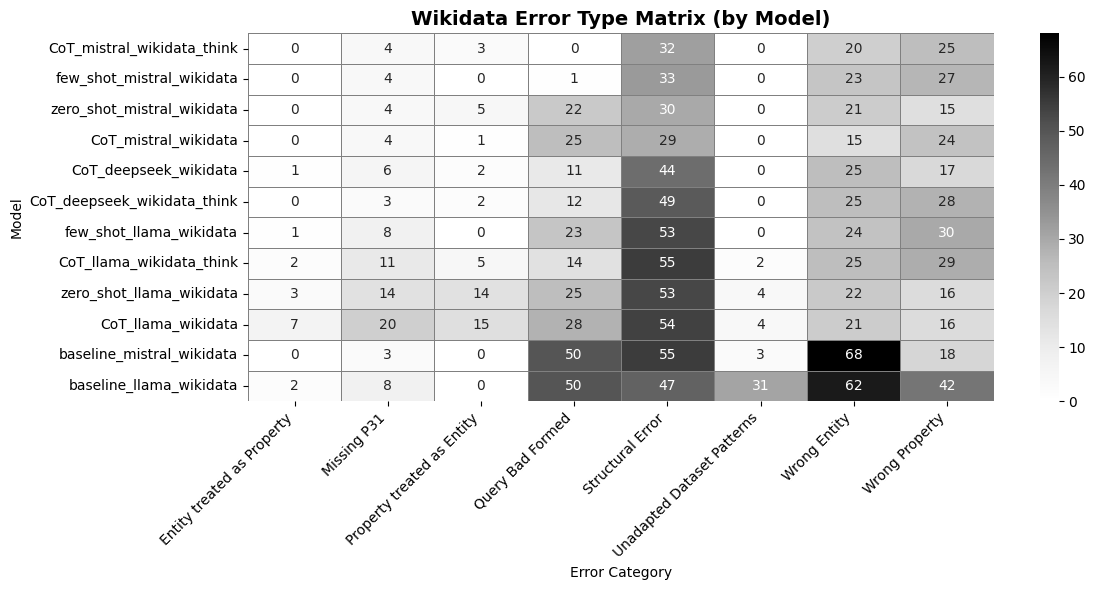

In [37]:
error_order = [
    "Entity treated as Property",
    "Missing P31",
    "Property treated as Entity",
    "Query Bad Formed",
    "Structural Error",
    "Unadapted Dataset Patterns",
    "Wrong Entity",
    "Wrong Property"
]

existing_cols = [col for col in error_order if col in wikidata_df.columns]
wikidata_df_ordered = wikidata_df[existing_cols]


# Plot Wikidata error matrix as heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(wikidata_df_ordered, annot=True, fmt="d", cmap="Greys", cbar=True, linewidths=.5, linecolor="gray")
plt.title("Wikidata Error Type Matrix (by Model)", fontsize=14, weight='bold')
plt.ylabel("Model")
plt.xlabel("Error Category")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

plt.savefig("wikidata_error_matrix.png", dpi=300)
plt.show()

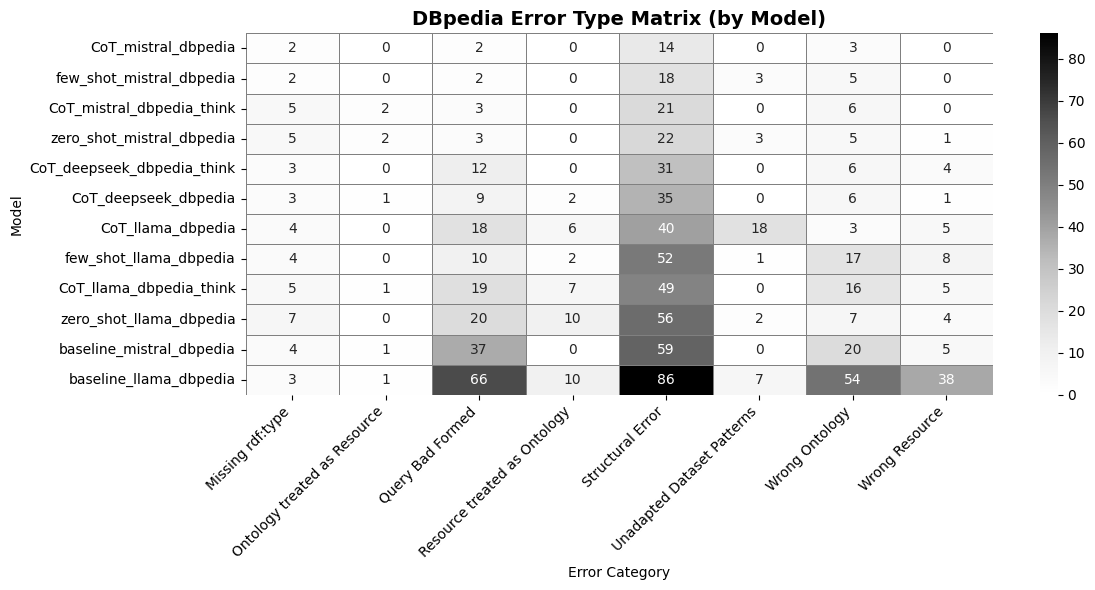

In [38]:
error_order_dbpedia = [
    "Missing rdf:type",
    "Ontology treated as Resource",
    "Query Bad Formed",
    "Resource treated as Ontology",
    "Structural Error",
    "Unadapted Dataset Patterns",
    "Wrong Ontology",
    "Wrong Resource"
]

existing_cols = [col for col in error_order_dbpedia if col in dbpedia_df.columns]
dbpedia_df_ordered = dbpedia_df[existing_cols]

# Plot DBpedia error matrix as heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(dbpedia_df_ordered, annot=True, fmt="d", cmap="Greys", cbar=True, linewidths=.5, linecolor="gray")
plt.title("DBpedia Error Type Matrix (by Model)", fontsize=14, weight='bold')
plt.ylabel("Model")
plt.xlabel("Error Category")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

plt.savefig("dbpedia_error_matrix.png", dpi=300)
plt.show()

In [9]:
error_cols = ["Error Category", "Error Category 2", "Error Category 3", "Error Category 4"]
file_paths = glob.glob("categorization/*_results_analysis.xlsx")

# Extract error sets per query for each KG
def collect_query_errors(paths):
    queries = {"wikidata": [], "dbpedia": []}
    for path in paths:
        df = pd.read_excel(path)
        model_name = os.path.basename(path).lower()
        df = df[df["Correct"] != True]
        error_sets = df[error_cols].dropna(how="all").apply(lambda row: set(row.dropna()), axis=1)
        if "wikidata" in model_name:
            queries["wikidata"].extend(error_sets)
        elif "dbpedia" in model_name:
            queries["dbpedia"].extend(error_sets)
    return queries

queries_by_kg = collect_query_errors(file_paths)


In [10]:
# Build one-hot and conditional Co-Occurrence matrix for each KG
def build_one_hot_matrix(error_sets):
    all_errors = sorted(set.union(*error_sets))
    one_hot = pd.DataFrame(0, index=range(len(error_sets)), columns=all_errors)
    for i, errors in enumerate(error_sets):
        one_hot.loc[i, list(errors)] = 1
    return one_hot

def build_conditional_matrix(one_hot):
    conditional = pd.DataFrame(index=one_hot.columns, columns=one_hot.columns, dtype=float)
    for error_a in one_hot.columns:
        queries_with_a = one_hot[one_hot[error_a] == 1]
        for error_b in one_hot.columns:
            if len(queries_with_a) == 0:
                conditional.loc[error_a, error_b] = 0.0
            else:
                prob = queries_with_a[error_b].sum() / len(queries_with_a)
                conditional.loc[error_a, error_b] = round(prob * 100, 1)
    return conditional

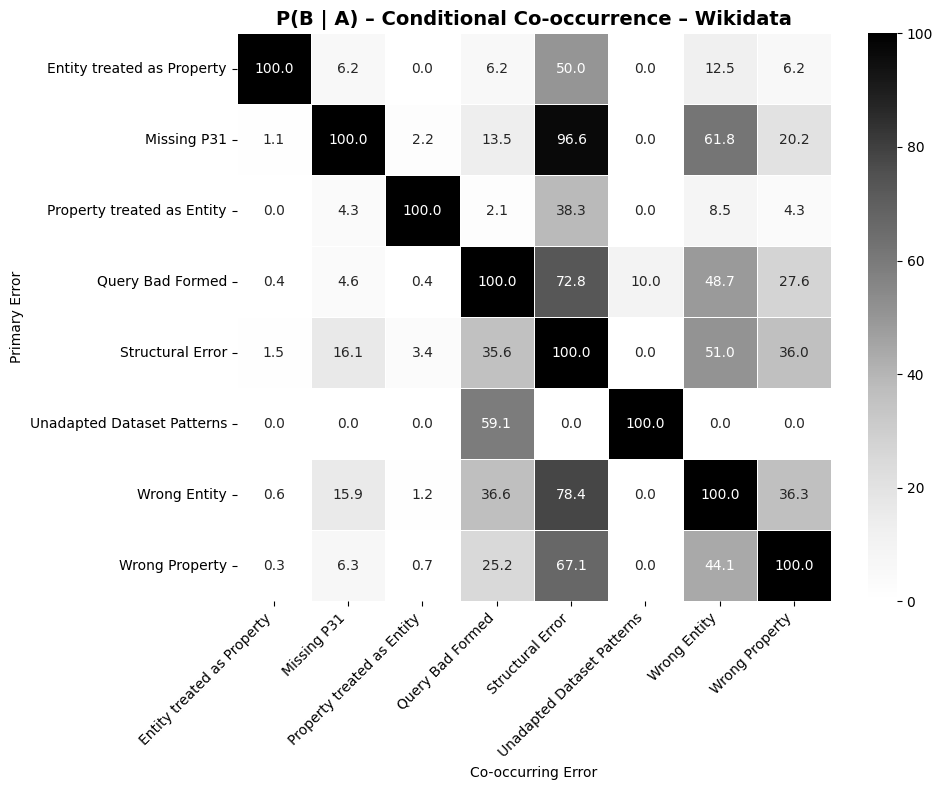

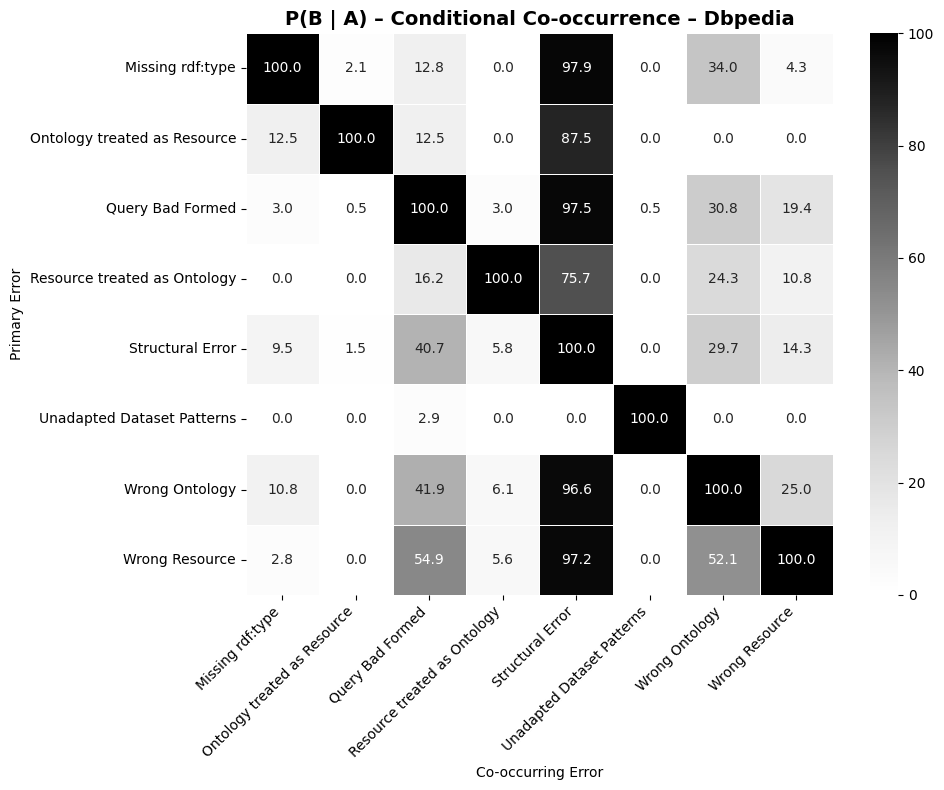

In [11]:
def plot_heatmap(matrix, title, filename):
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, fmt=".1f", cmap="Greys", linewidths=.5)
    plt.title(title, fontsize=14, weight='bold')
    plt.xlabel("Co-occurring Error")
    plt.ylabel("Primary Error")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

for kg in ["wikidata", "dbpedia"]:
    one_hot = build_one_hot_matrix(queries_by_kg[kg])
    conditional = build_conditional_matrix(one_hot)
    plot_heatmap(
        conditional,
        f"P(B | A) – Conditional Co-occurrence – {kg.title()}",
        f"{kg}_conditional_heatmap.png"
    )


Calculate overall error distribution per query

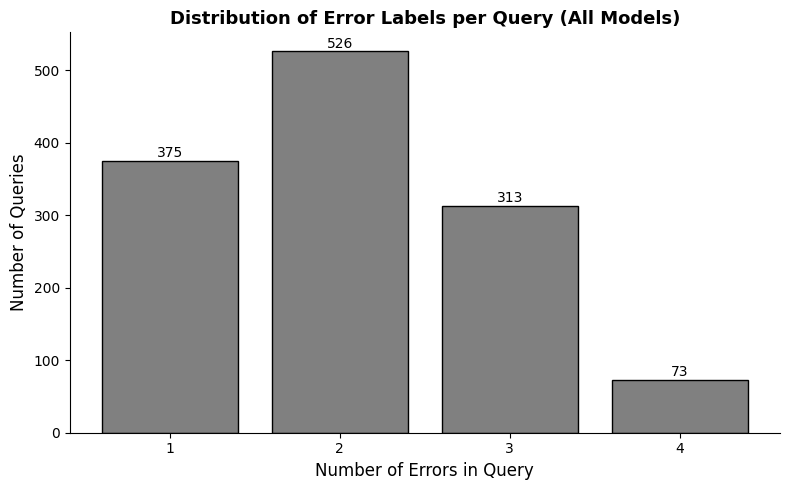

In [12]:
error_cols = ["Error Category", "Error Category 2", "Error Category 3", "Error Category 4"]
all_error_counts = []

# Collect number of error labels per incorrect query
for path in glob.glob("categorization/*_results_analysis.xlsx"):
    df = pd.read_excel(path)
    df_errors = df[df['Correct'] != True]    
    error_counts = df_errors[error_cols].notna().sum(axis=1)
    all_error_counts.extend(error_counts.tolist())

# Series of error counts per query
error_count_series = pd.Series(all_error_counts)
value_counts = error_count_series.value_counts().sort_index()

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(value_counts.index, value_counts.values, color='gray', edgecolor='black')

# Add exact value labels on top
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 1,
        f"{int(height)}",
        ha='center',
        va='bottom',
        fontsize=10
    )
# Styling
plt.xlabel("Number of Errors in Query", fontsize=12)
plt.ylabel("Number of Queries", fontsize=12)
plt.title("Distribution of Error Labels per Query (All Models)", fontsize=13, weight='bold')
plt.xticks(ticks=[1, 2, 3, 4])
sns.despine()
plt.tight_layout()
plt.savefig("error_label_count_distribution.png", dpi=300)
plt.show()

Create normalized error frequency heatmaps per model per KG

In [13]:
error_cols = ["Error Category", "Error Category 2", "Error Category 3", "Error Category 4"]

wikidata_error_counts = []
wikidata_total_errors = {}
wikidata_correct_counts = {}

dbpedia_error_counts = []
dbpedia_total_errors = {}
dbpedia_correct_counts = {}

for path in glob.glob("categorization/*_results_analysis.xlsx"):
    model_name = os.path.basename(path).replace("_results_analysis.xlsx", "")
    df = pd.read_excel(path)
    df_original = df.copy()

    df_errors = df[df["Correct"] != True].copy()
    total_incorrect = len(df_errors)

    # Stack errors
    stacked = df_errors[error_cols].stack().reset_index(drop=True)
    error_counts = stacked.value_counts().to_dict()
    error_counts["Model"] = model_name

    # Split by KG
    if "wikidata" in model_name.lower():
        wikidata_error_counts.append(error_counts)
        wikidata_total_errors[model_name] = total_incorrect
        wikidata_correct_counts[model_name] = df_original["Correct"].sum()
    elif "dbpedia" in model_name.lower():
        dbpedia_error_counts.append(error_counts)
        dbpedia_total_errors[model_name] = total_incorrect
        dbpedia_correct_counts[model_name] = df_original["Correct"].sum()


In [39]:
def normalize_and_plot(error_counts_list, total_errors_dict, correct_counts_dict, title, filename):
    # Raw error matrix
    matrix = pd.DataFrame(error_counts_list).fillna(0).set_index("Model").astype(float)

    # Normalize by incorrect queries
    for model in matrix.index:
        total = total_errors_dict.get(model, 1)
        matrix.loc[model] = (matrix.loc[model] / total * 100).round(1).astype(float)

    # Sort by number of correct answers
    sorted_models = sorted(correct_counts_dict.items(), key=lambda x: x[1], reverse=True)
    sorted_model_names = [model for model, _ in sorted_models]
    matrix = matrix.loc[matrix.index.intersection(sorted_model_names)]
    matrix = matrix.reindex(sorted_model_names)
    
    # Sort the x-axis (columns) alphabetically
    matrix = matrix.reindex(sorted(matrix.columns), axis=1)

    # Plot
    plt.figure(figsize=(12, 7))
    sns.heatmap(matrix, annot=True, fmt=".1f", cmap="Greys", linewidths=0.5)
    plt.title(f"{title}\n(% of Incorrect Queries)", fontsize=14, weight="bold")
    plt.xlabel("Error Type", fontsize=12)
    plt.ylabel("Model (sorted by accuracy)", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()


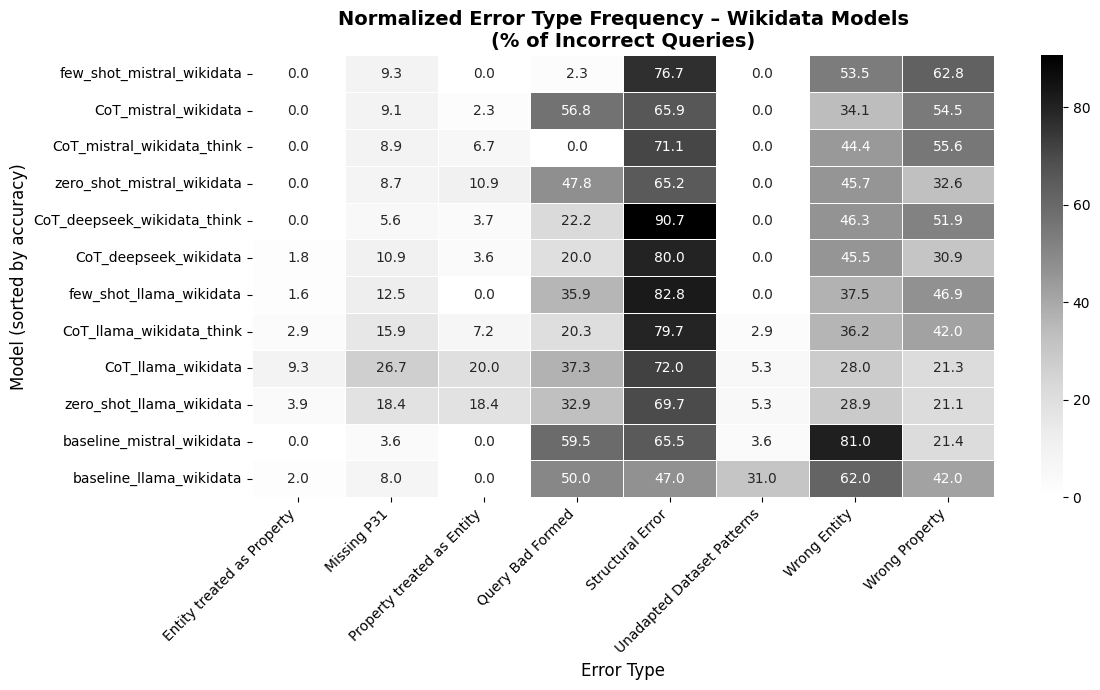

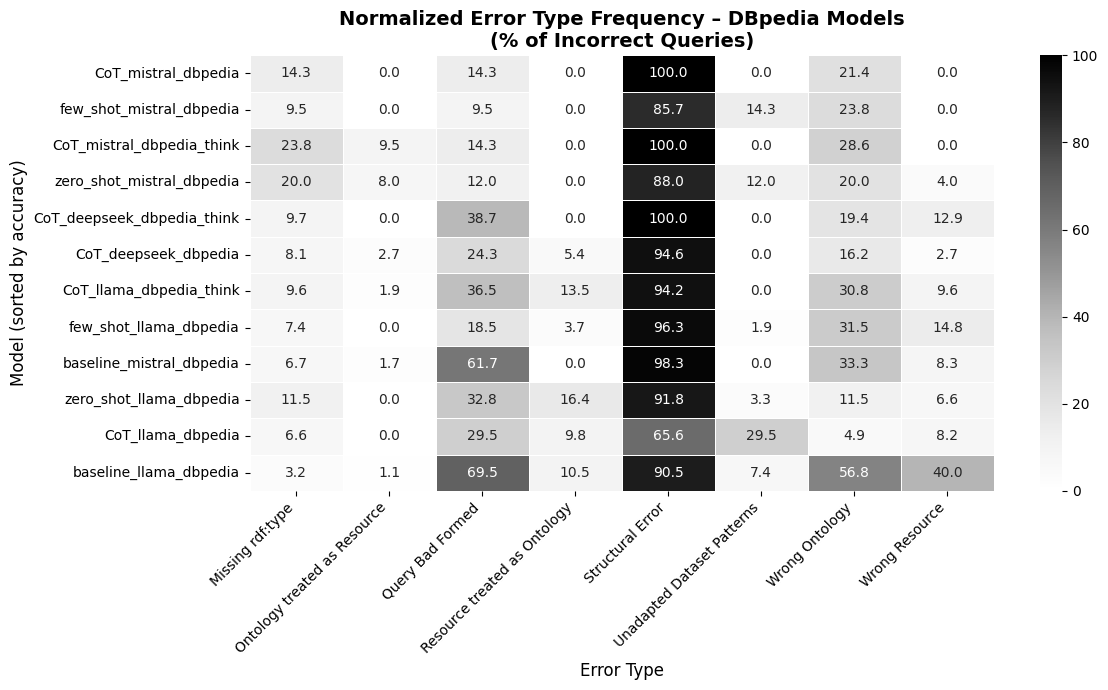

In [40]:
normalize_and_plot(
    wikidata_error_counts,
    wikidata_total_errors,
    wikidata_correct_counts,
    "Normalized Error Type Frequency – Wikidata Models",
    "heatmap_normalized_wikidata_sorted.png"
)

normalize_and_plot(
    dbpedia_error_counts,
    dbpedia_total_errors,
    dbpedia_correct_counts,
    "Normalized Error Type Frequency – DBpedia Models",
    "heatmap_normalized_dbpedia_sorted.png"
)

In [30]:
error_matrix = pd.DataFrame(wikidata_error_counts + dbpedia_error_counts).fillna(0).set_index("Model").astype(int)

# Map each model name to a prompting method
method_map = {
    "baseline_llama_wikidata": "baseline",
    "baseline_llama_dbpedia": "baseline",
    "baseline_mistral_wikidata": "baseline",
    "baseline_mistral_dbpedia": "baseline",
    "few_shot_mistral_wikidata": "few-shot",
    "few_shot_mistral_dbpedia": "few-shot",
    "few_shot_llama_wikidata": "few-shot",
    "few_shot_llama_dbpedia": "few-shot",
    "CoT_llama_wikidata": "CoT",
    "CoT_llama_dbpedia": "CoT",
    "CoT_mistral_wikidata": "CoT",
    "CoT_mistral_dbpedia": "CoT",
    "CoT_deepseek_wikidata": "CoT",
    "CoT_deepseek_dbpedia": "CoT",
    "CoT_llama_wikidata_think": "CoT + <think>",
    "CoT_llama_dbpedia_think": "CoT + <think>",
    "CoT_mistral_wikidata_think": "CoT + <think>",
    "CoT_mistral_dbpedia_think": "CoT + <think>",
    "CoT_deepseek_wikidata_think": "CoT + <think>",
    "CoT_deepseek_dbpedia_think": "CoT + <think>",
}

# Add Method column to the matrix
error_matrix["Method"] = error_matrix.index.map(method_map)

# Split into Wikidata and DBpedia
wikidata_error_matrix = error_matrix[error_matrix.index.str.contains("wikidata", case=False)].copy()
dbpedia_error_matrix = error_matrix[error_matrix.index.str.contains("dbpedia", case=False)].copy()


In [31]:
# Define error label unification
label_aliases = {
    # Equivalents between DBpedia and Wikidata
    "Wrong Ontology": "Wrong Property",
    "Wrong Resource": "Wrong Entity",
    "Missing rdf:type": "Missing P31",
    "Resource treated as Ontology": "Entity treated as Property",
    "Ontology treated as Resource": "Property treated as Entity",

    # Identity mapping for shared or unchanged labels
    "Wrong Property": "Wrong Property",
    "Wrong Entity": "Wrong Entity",
    "Missing P31": "Missing P31",
    "Structural Error": "Structural Error",
    "Query Bad Formed": "Query Bad Formed",
    "Unadapted Dataset Patterns": "Unadapted Dataset Patterns"
}

# Use your own hex color palette
custom_colors = [
    "#000000", "#E69F00", "#F0E442", "#009E73",
    "#56B4E9", "#0072B2", "#D55E00", "#CC79A7"
]

# Unified label set and color mapping
unified_labels = sorted(set(label_aliases.values()))
color_dict = dict(zip(unified_labels, custom_colors[:len(unified_labels)]))


In [32]:
def plot_method_error_distribution(df, title, filename, normalize=False):
    grouped = df.groupby("Method").sum(numeric_only=True)

    # Drop unused error types
    used_errors = [col for col in grouped.columns if grouped[col].sum() > 0]
    grouped = grouped[used_errors]

    # Sort methods by total errors (descending)
    grouped["Total"] = grouped.sum(axis=1)
    grouped = grouped.sort_values("Total", ascending=False).drop(columns="Total")

    # Normalize if requested
    if normalize:
        grouped = grouped.div(grouped.sum(axis=1), axis=0) * 100

    # Assign colors using your alias/color maps
    error_colors = [color_dict[label_aliases.get(label, label)] for label in grouped.columns]

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    grouped.plot(kind="bar", stacked=True, ax=ax, color=error_colors)

    ax.set_title(title, fontsize=14, weight="bold")
    ax.set_ylabel("Percentage of Errors" if normalize else "Total Errors", fontsize=12)
    ax.set_xlabel("Prompting Method", fontsize=12)
    ax.set_xticks(range(len(grouped.index)))
    ax.set_xticklabels(grouped.index, rotation=0)
    ax.legend(title="Error Type", bbox_to_anchor=(1.05, 1), loc="upper left")

    sns.despine()
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

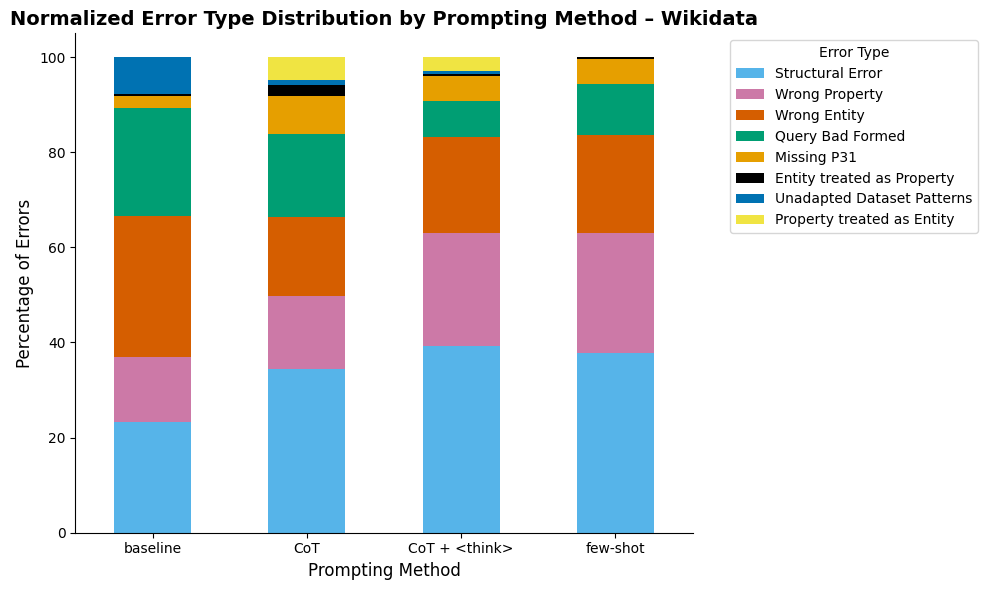

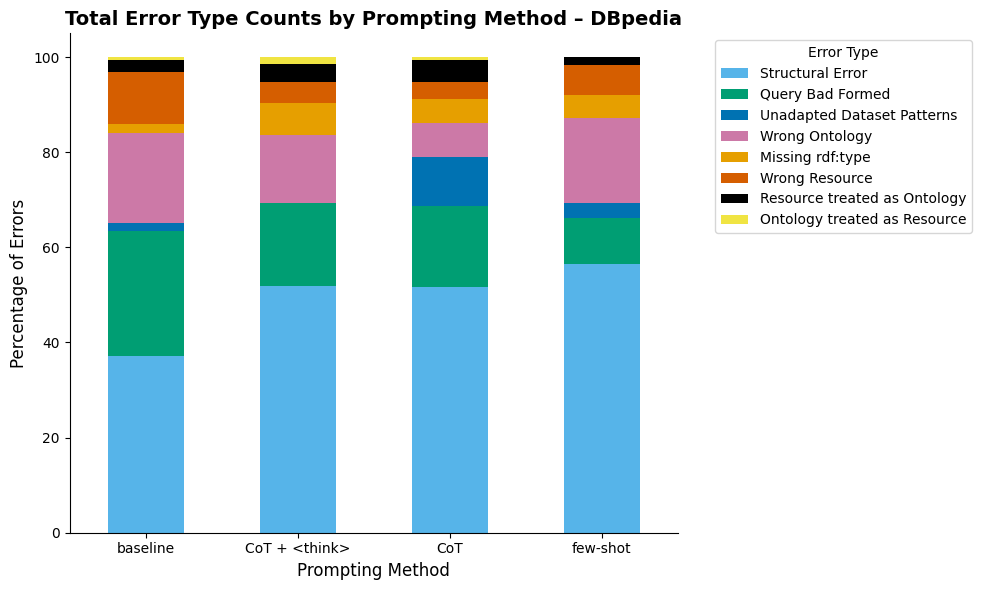

In [33]:
plot_method_error_distribution(
    wikidata_error_matrix,
    "Normalized Error Type Distribution by Prompting Method – Wikidata",
    "errors_by_method_wikidata_percent.png",
    normalize=True
)

# For raw counts
plot_method_error_distribution(
    dbpedia_error_matrix,
    "Total Error Type Counts by Prompting Method – DBpedia",
    "errors_by_method_dbpedia_total.png",
    normalize=True
)

Sort Error Type legend alphabetically

In [ ]:
# Load question categories
question_cat = pd.read_excel("question_categories.xlsx")
question_cat = question_cat.rename(columns={"category": "question_category", "question": "question_text"})
question_cat["question_text"] = question_cat["question_text"].str.strip()

# Extract and merge error data
error_cols = ["Error Category", "Error Category 2", "Error Category 3", "Error Category 4"]
all_errors = []

for path in glob.glob("categorization/*_results_analysis.xlsx"):
    df = pd.read_excel(path)
    df = df[df["Correct"] != True]
    model_name = os.path.basename(path).replace("_results_analysis.xlsx", "")
    kg = "wikidata" if "wikidata" in model_name.lower() else "dbpedia"
    df["kg"] = kg

    df = df.rename(columns={"Question": "question_text"})
    df["question_text"] = df["question_text"].str.strip()

    melted = df[["question_text", "kg"] + error_cols].melt(id_vars=["question_text", "kg"], value_name="error_category")
    melted = melted.dropna()
    all_errors.append(melted)

# Combine all error rows
error_df = pd.concat(all_errors, ignore_index=True)
error_df = error_df.merge(question_cat, on="question_text", how="left")

# Total number of errors per category
total_errors = error_df.groupby(["kg", "question_category"]).size().reset_index(name="Total Errors")

# Unique number of queries per category
unique_q = error_df.drop_duplicates(subset=["question_text", "kg"])
queries_per_cat = unique_q.groupby(["kg", "question_category"]).size().reset_index(name="Num Queries")

# Merge stats
merged_stats = total_errors.merge(queries_per_cat, on=["kg", "question_category"])

# Normalize by number of queries × models
NUM_MODELS = 12
merged_stats["Avg Errors per Prediction"] = (
    merged_stats["Total Errors"] / (merged_stats["Num Queries"] * NUM_MODELS)
).round(2)


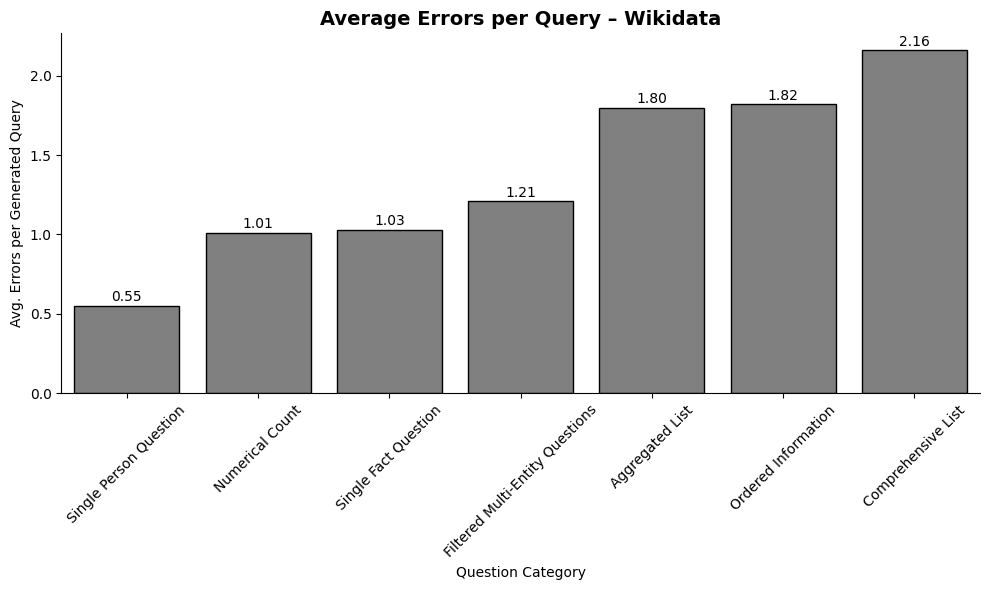

In [35]:
# Filter and sort for Wikidata
wikidata_sorted = merged_stats[merged_stats["kg"] == "wikidata"].sort_values("Avg Errors per Prediction")

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=wikidata_sorted,
    x="question_category",
    y="Avg Errors per Prediction",
    hue="question_category",
    palette="Blues_d",
    legend=False
)

for bar in ax.patches:
    bar.set_facecolor('gray')
    bar.set_edgecolor('black')

# Add values on top of bars
for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.01,
        f"{height:.2f}",
        ha='center',
        va='bottom',
        fontsize=10
    )

# Aesthetics
ax.set_title("Average Errors per Query – Wikidata", fontsize=14, weight='bold')
ax.set_ylabel("Avg. Errors per Generated Query")
ax.set_xlabel("Question Category")
sns.despine()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Recap of the Calculation
You're now plotting:

Avg Errors per Model-Query Prediction
=
Total Errors in that category
÷
(Number of distinct queries × Number of models)

What does 2.16 mean for “Comprehensive List”?
It means:

On average, each model made 2.16 error labels per query classified as a "Comprehensive List" question.

More intuitively:
Every time a model was presented with a query of that type,

it generated nearly 2 different types of errors (from the 4 possible slots),

on average, across all queries in that category.

“On average, models produced 2.16 distinct error labels per prediction when handling Comprehensive List queries, making them the most error-prone question category in the benchmark.”



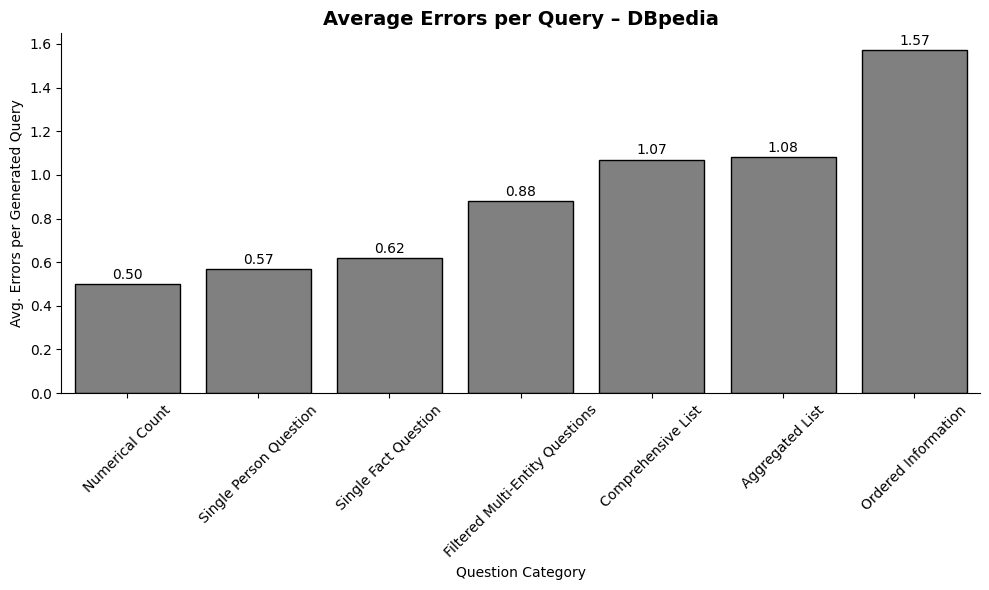

In [36]:
# Filter and sort for Wikidata
wikidata_sorted = merged_stats[merged_stats["kg"] == "dbpedia"].sort_values("Avg Errors per Prediction")

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=wikidata_sorted,
    x="question_category",
    y="Avg Errors per Prediction",
    hue="question_category",
    palette="Blues_d",
    legend=False
)

for bar in ax.patches:
    bar.set_facecolor('gray')
    bar.set_edgecolor('black')

# Add values on top of bars
for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.01,
        f"{height:.2f}",
        ha='center',
        va='bottom',
        fontsize=10
    )

# Aesthetics
ax.set_title("Average Errors per Query – DBpedia", fontsize=14, weight='bold')
ax.set_ylabel("Avg. Errors per Generated Query")
ax.set_xlabel("Question Category")
sns.despine()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()